# EDA


In [1]:
# Import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('../../data/processed_data.csv')

# Print column names
print(data.columns)

# Make date column datetime
data['Date'] = pd.to_datetime(data['Date'])

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker',
       'ln_hourly_return', 'ln_3_hourly_return', 'ln_daily_return',
       'ln_hourly_rv', 'ln_3_hourly_rv', 'ln_daily_rv', 'ln_weekly_rv',
       'ln_monthly_rv', 'ln_hourly_rv_lag1', 'ln_3_hourly_rv_lag1',
       'ln_daily_rv_lag1', 'ln_weekly_rv_lag1', 'ln_monthly_rv_lag1', 'Risk'],
      dtype='object')


## Daily Returns vs RV

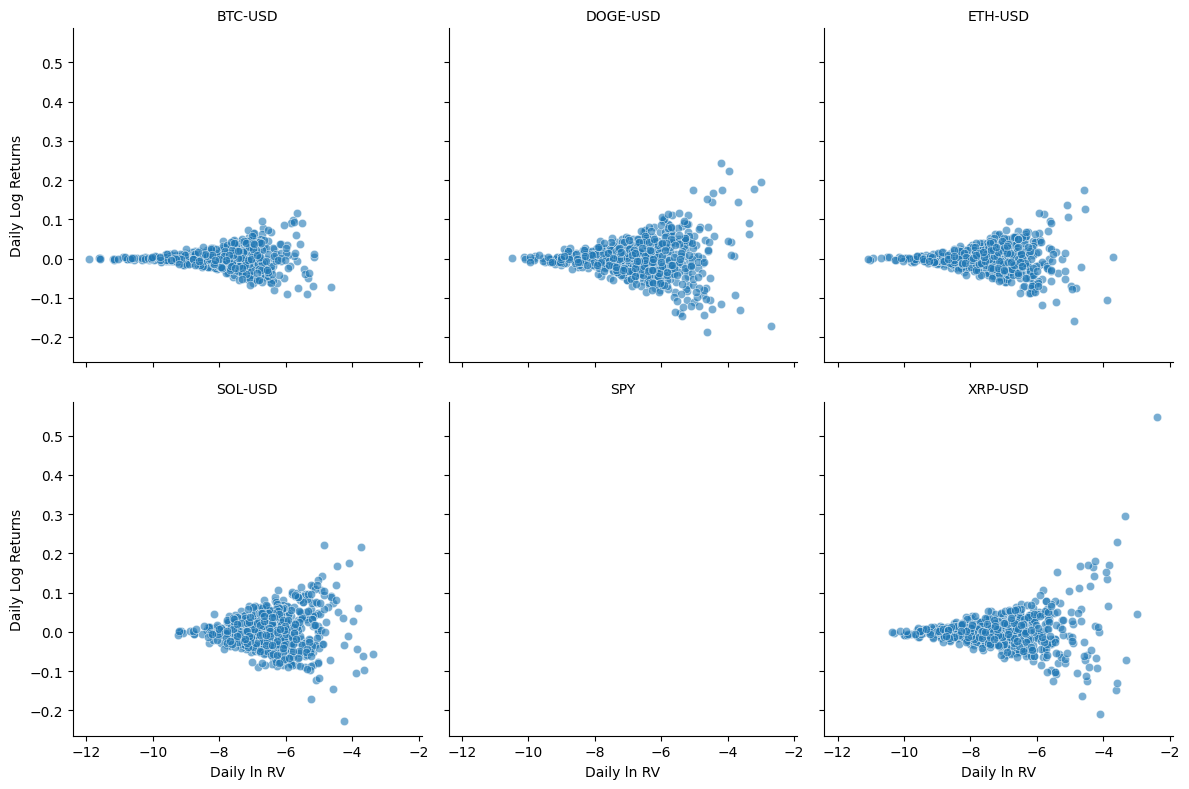

Ticker
BTC-USD     0.001449
DOGE-USD    0.000913
ETH-USD     0.000047
SOL-USD     0.002494
SPY              NaN
XRP-USD     0.001877
Name: ln_daily_return, dtype: float64
Ticker
BTC-USD     -7.940902
DOGE-USD    -6.815516
ETH-USD     -7.547093
SOL-USD     -6.502131
SPY        -10.257267
XRP-USD     -7.171542
Name: ln_daily_rv, dtype: float64


In [2]:
g = sns.FacetGrid(data=data, col='Ticker', col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.scatterplot, 'ln_daily_rv', 'ln_daily_return', alpha=0.6)
g.set_titles("{col_name}")
g.set_axis_labels("Daily ln RV", "Daily Log Returns")
plt.tight_layout()
plt.show()

# Calculate the mean of the daily log returns
mean_daily_return = data.groupby('Ticker')['ln_daily_return'].mean()
mean_daily_rv= data.groupby('Ticker')['ln_daily_rv'].mean()
print(mean_daily_return)
print(mean_daily_rv)

### RV Trends

C:\Users\young\AppData\Local\Temp\ipykernel_30508\336401711.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(0.05, 0.95, f"Mean RV: {mean_daily_rv[i]:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')


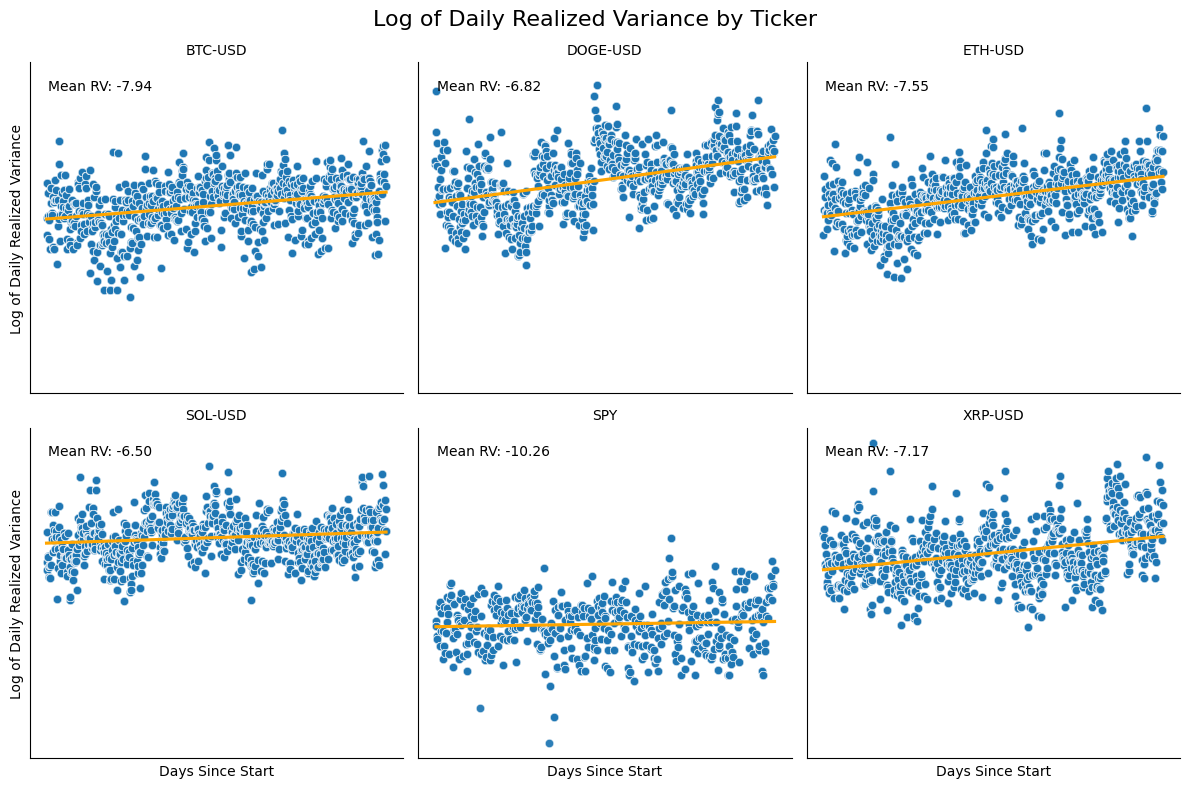

In [3]:
# Ensure Date is datetime
data['Date'] = pd.to_datetime(data['Date'])

# Convert Date to numerical format for regression (days since the first date)
data['Days_Since_Start'] = (data['Date'] - data['Date'].min()).dt.days

# Plot the hourly log returns for all tickers
g = sns.FacetGrid(data=data, col='Ticker', col_wrap=3, height=4, sharex=True, sharey=True)

# Map scatterplot to each facet
g.map(sns.scatterplot, 'Days_Since_Start', 'ln_daily_rv', alpha=0.6)

# Add a regression line to each facet
g.map(sns.regplot, 'Days_Since_Start', 'ln_daily_rv', scatter=False, color='orange')

# Set titles and axis labels
g.set_titles("{col_name}", fontsize=12)  # Adjust title font size
g.set_axis_labels("Days Since Start", "Log of Daily Realized Variance")  # Correct axis labels

# Add gridlines for better readability
g.set(xticks=[], yticks=[])  # Remove default ticks if not needed
g.fig.subplots_adjust(top=0.9)  # Adjust spacing for titles
g.fig.suptitle('Log of Daily Realized Variance by Ticker', fontsize=16)  # Add an overall title

# Add their coefficients to the plot
for i, ax in enumerate(g.axes.flat):
    ax.text(0.05, 0.95, f"Mean RV: {mean_daily_rv[i]:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

# Correlation plots of returns

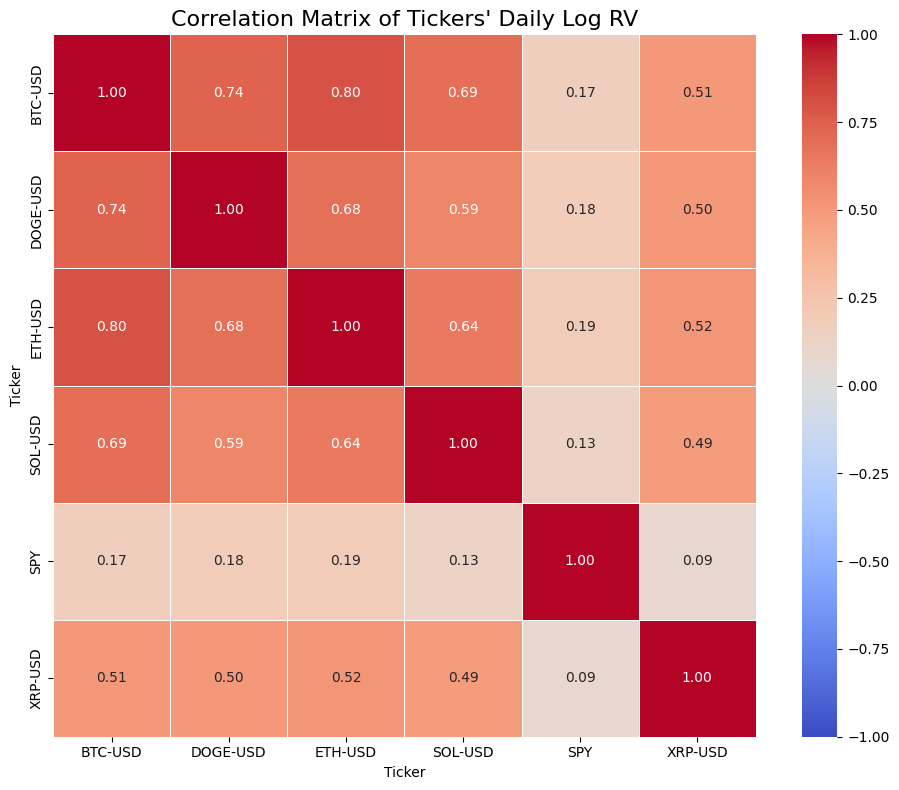

In [4]:
import seaborn as sns

# Resample data to daily frequency and keep Ticker/Date as columns
data_resampled = (
    data.groupby('Ticker')  # Group by Ticker column
    .resample('D', on='Date')  # Resample to daily frequency
    .last()  # Use the last observation of each day
    .drop(columns=['Ticker'])  # Drop the duplicate Ticker column
    .reset_index()  # Convert MultiIndex (Ticker, Date) to columns
)

# Calculate daily log RV (aligned with the DataFrame's index)
data_resampled['ln_daily_rv'] = (
    data_resampled.groupby('Ticker')['Close']
    .transform(lambda x: np.log(x).diff())  # Align indices automatically
)

# Drop rows with NaN in ln_daily_rv (first row for each ticker)
data_resampled = data_resampled.dropna(subset=['ln_daily_rv'])

# Pivot the data to have one column per ticker's daily log returns
daily_returns_pivot = data_resampled.pivot(index='Date', columns='Ticker', values='ln_daily_rv')

# Fill missing values and clean up
daily_returns_pivot = daily_returns_pivot.ffill().bfill().dropna()

# Calculate the correlation matrix
correlation_matrix = daily_returns_pivot.corr()


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Annotate the heatmap with correlation values
    fmt=".2f",  # Format the annotations to 2 decimal places
    cmap="coolwarm",  
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,  # Ensure the plot is square
)
plt.title('Correlation Matrix of Tickers\' Daily Log RV', fontsize=16)
plt.tight_layout()
plt.show()